# Notebook #2
## Multi_Model_RAG
#### https://github.com/langchain-ai/langchain/blob/master/cookbook/Multi_modal_RAG.ipynb
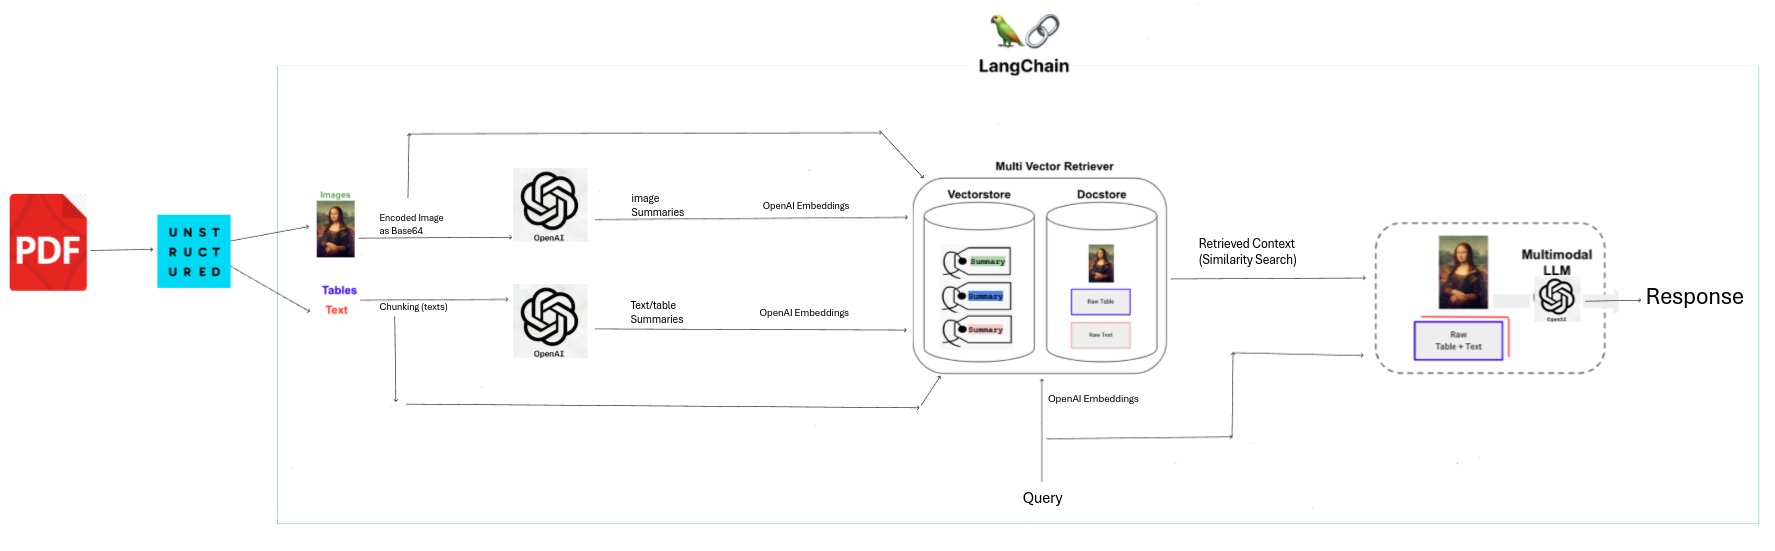

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

# PDF Extraction and Categorization

This section demonstrates how to extract content from a PDF file, categorize the extracted elements into text and tables, and optionally split the text into manageable chunks for further processing.

1. **Extract PDF Elements**
   The `extract_pdf_elements` function uses the `unstructured.partition.pdf` package to process a PDF file. The function performs the following tasks:
   - Extracts both images and tables from the PDF.
   - Divides the text into chunks based on titles 

2. **Categorize Extracted Elements**
   The `categorize_elements` function processes the raw elements extracted from the PDF. It distinguishes between tables and textual content by checking the type of each element. If the element is a table, it is added to the `tables` list, while non-table elements are considered as text and are added to the `texts` list.

3. **Text Chunking**
   After extracting the text, the code uses the `CharacterTextSplitter` class from LangChain to split the text into chunks with a size limit of 4000 characters. This chunking is useful for processing large text documents that may exceed token limits for models or other tools.

In [2]:
from langchain_text_splitters import CharacterTextSplitter
from unstructured.partition.pdf import partition_pdf


# Extract elements from PDF
def extract_pdf_elements(path, fname):
    """
    Extract images, tables, and chunk text from a PDF file.
    path: File path, which is used to dump images (.jpg)
    fname: File name
    """
    return partition_pdf(
        filename=path + fname,
        extract_images_in_pdf=True,
        infer_table_structure=True,
        chunking_strategy="by_title",
        max_characters=4000,
        new_after_n_chars=3800,
        combine_text_under_n_chars=2000,
        image_output_dir_path=path,
    )


# Categorize elements by type
def categorize_elements(raw_pdf_elements):
    """
    Categorize extracted elements from a PDF into tables and texts.
    raw_pdf_elements: List of unstructured.documents.elements
    """
    tables = []
    texts = []
    for element in raw_pdf_elements:
        if "unstructured.documents.elements.Table" in str(type(element)):
            tables.append(str(element))
        elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
            texts.append(str(element))
    return texts, tables


# File path
fpath = "/home/vino/ML_Projects/MDTS_tasks/cj/"
fname = "cj.pdf"

# Get elements
raw_pdf_elements = extract_pdf_elements(fpath, fname)

# Get text, tables
texts, tables = categorize_elements(raw_pdf_elements)

# Optional: Enforce a specific token size for texts
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=4000, chunk_overlap=0
)
joined_texts = " ".join(texts)
texts_4k_token = text_splitter.split_text(joined_texts)

Created a chunk of size 4112, which is longer than the specified 4000


# Text and Table Summarization
Here concise summaries for text and table elements extracted from a PDF file are generated using GPT-4. 
The summaries are designed for retrieval tasks, where the goal is to produce optimized, concise content that can be embedded for RAG


In [3]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI


# Generate summaries of text elements
def generate_text_summaries(texts, tables, summarize_texts=False):
    """
    Summarize text elements
    texts: List of str
    tables: List of str
    summarize_texts: Bool to summarize texts
    """

    # Prompt
    prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
    These summaries will be embedded and used to retrieve the raw text or table elements. \
    Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element} """
    prompt = ChatPromptTemplate.from_template(prompt_text)

    # Text summary chain
    model = ChatOpenAI(temperature=0, model="gpt-4",openai_api_key=openai_api_key)
    summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

    # Initialize empty summaries
    text_summaries = []
    table_summaries = []

    # Apply to text if texts are provided and summarization is requested
    if texts and summarize_texts:
        text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})
    elif texts:
        text_summaries = texts

    # Apply to tables if tables are provided
    if tables:
        table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

    return text_summaries, table_summaries


# Get text, table summaries
text_summaries, table_summaries = generate_text_summaries(
    texts_4k_token, tables, summarize_texts=True
)

# Image Summarization and Base64 Encoding

This code demonstrates how to process and generate summaries for images, using the GPT-4o model. The images are encoded into base64 format for easier transmission and embedding, and the summaries are designed for RAG.

1. The function `generate_img_summaries` is called with the path to the directory containing the images.
2. For each image:
   - The image is encoded into a base64 string using `encode_image`.
   - A summary is generated for the image using `image_summarize`.
3. The resulting base64 strings and summaries are returned in two lists: `img_base64_list` and `image_summaries`.



In [4]:
import base64
import os

from langchain_core.messages import HumanMessage


def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def image_summarize(img_base64, prompt):
    """Make image summary"""
    chat = ChatOpenAI(model="gpt-4o", max_tokens=1024,openai_api_key=openai_api_key)

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content


def generate_img_summaries(path):
    """
    Generate summaries and base64 encoded strings for images
    path: Path to list of .jpg files extracted by Unstructured
    """

    # Store base64 encoded images
    img_base64_list = []

    # Store image summaries
    image_summaries = []

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""

    # Apply to images
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(base64_image, prompt))

    return img_base64_list, image_summaries


# Image summaries
img_base64_list, image_summaries = generate_img_summaries(fpath)

# Multi-Vector Retriever for Text, Table, and Image Summaries

This code demonstrates how to create a multi-vector retriever that indexes summaries of text, tables, and images, while storing and returning the raw contents of those elements. 

1. **Initialize the Vectorstore:** 
   The `Chroma` vectorstore is initialized with OpenAI embeddings for indexing the summaries.
   
2. **Create the Multi-Vector Retriever:**
   The `create_multi_vector_retriever` function is called with the vectorstore and the extracted summaries for texts, tables, and images.
   
3. **Index Documents:** 
   Texts, tables, and images are indexed along with their summaries, allowing for efficient retrieval based on the summaries.
   
4. **Use the Retriever:** 
   The `retriever_multi_vector_img` can now be used to search for relevant documents by querying the summaries and retrieving the corresponding raw content.


In [5]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings


def create_multi_vector_retriever(
    vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images
):
    """
    Create retriever that indexes summaries, but returns raw images or texts
    """

    # Initialize the storage layer
    store = InMemoryStore()
    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    # Add texts, tables, and images
    # Check that text_summaries is not empty before adding
    if text_summaries:
        add_documents(retriever, text_summaries, texts)
    # Check that table_summaries is not empty before adding
    if table_summaries:
        add_documents(retriever, table_summaries, tables)
    # Check that image_summaries is not empty before adding
    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever


# The vectorstore to use to index the summaries
vectorstore = Chroma(
    collection_name="mm_rag_cj_blog", embedding_function=OpenAIEmbeddings()
)

# Create retriever
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore,
    text_summaries,
    texts,
    table_summaries,
    tables,
    image_summaries,
    img_base64_list,
)


# Multi-Modal Retrieval-Augmented Generation (RAG) Pipeline

This code demonstrates the process of setting up a multi-modal Retrieval-Augmented Generation (RAG) chain using text, tables, and images (in base64 format). The goal is to integrate these different content types into a unified system that can analyze and generate outputs  based on the combined data.


In [ ]:
import io
import re

from IPython.display import HTML, display
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from PIL import Image


def plt_img_base64(img_base64):
    """Disply base64 encoded string as image"""
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    """
    Join the context into a single string
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            "You are financial analyst tasking with providing investment advice.\n"
            "You will be given a mixed of text, tables, and image(s) usually of charts or graphs.\n"
            "Use this information to provide investment advice related to the user question. \n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever):
    """
    Multi-modal RAG chain
    """

    # Multi-modal LLM
    model = ChatOpenAI(temperature=0, model="gpt-4o", max_tokens=1024, openai_api_key=openai_api_key)

    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain


# Create RAG chain
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)

In [7]:
# Check retrieval
query = "Give me company names that are interesting investments based on EV / NTM and NTM rev growth. Consider EV / NTM multiples vs historical?"
docs = retriever_multi_vector_img.invoke(query, limit=6)

# We get 4 docs
len(docs)

4

In [8]:
# Check retrieval
query = "What are the EV / NTM and NTM rev growth for MongoDB, Cloudflare, and Datadog?"
docs = retriever_multi_vector_img.invoke(query, limit=6)

# We get 4 docs
len(docs)

4


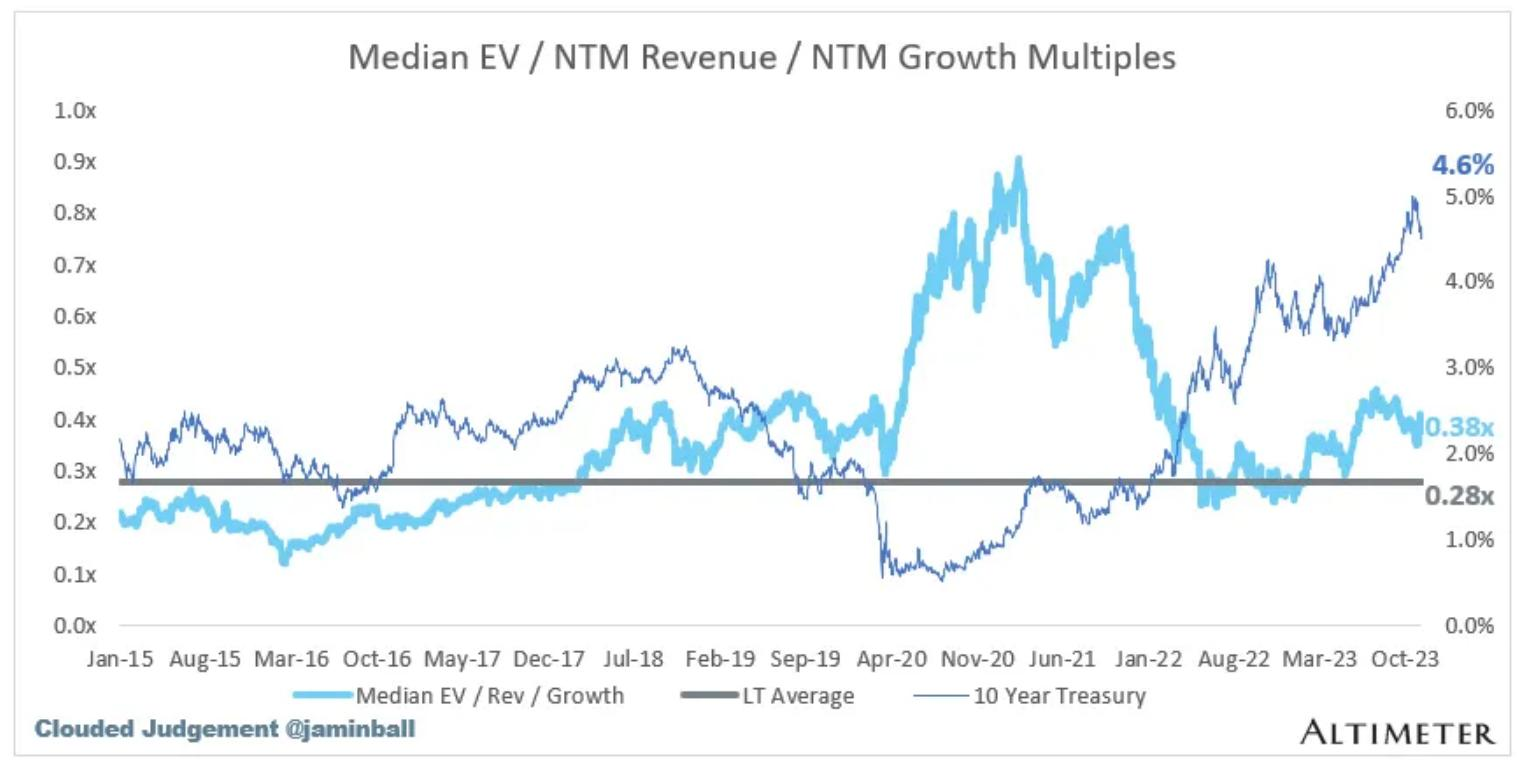

In [9]:
# We get back relevant images
plt_img_base64(docs[2])


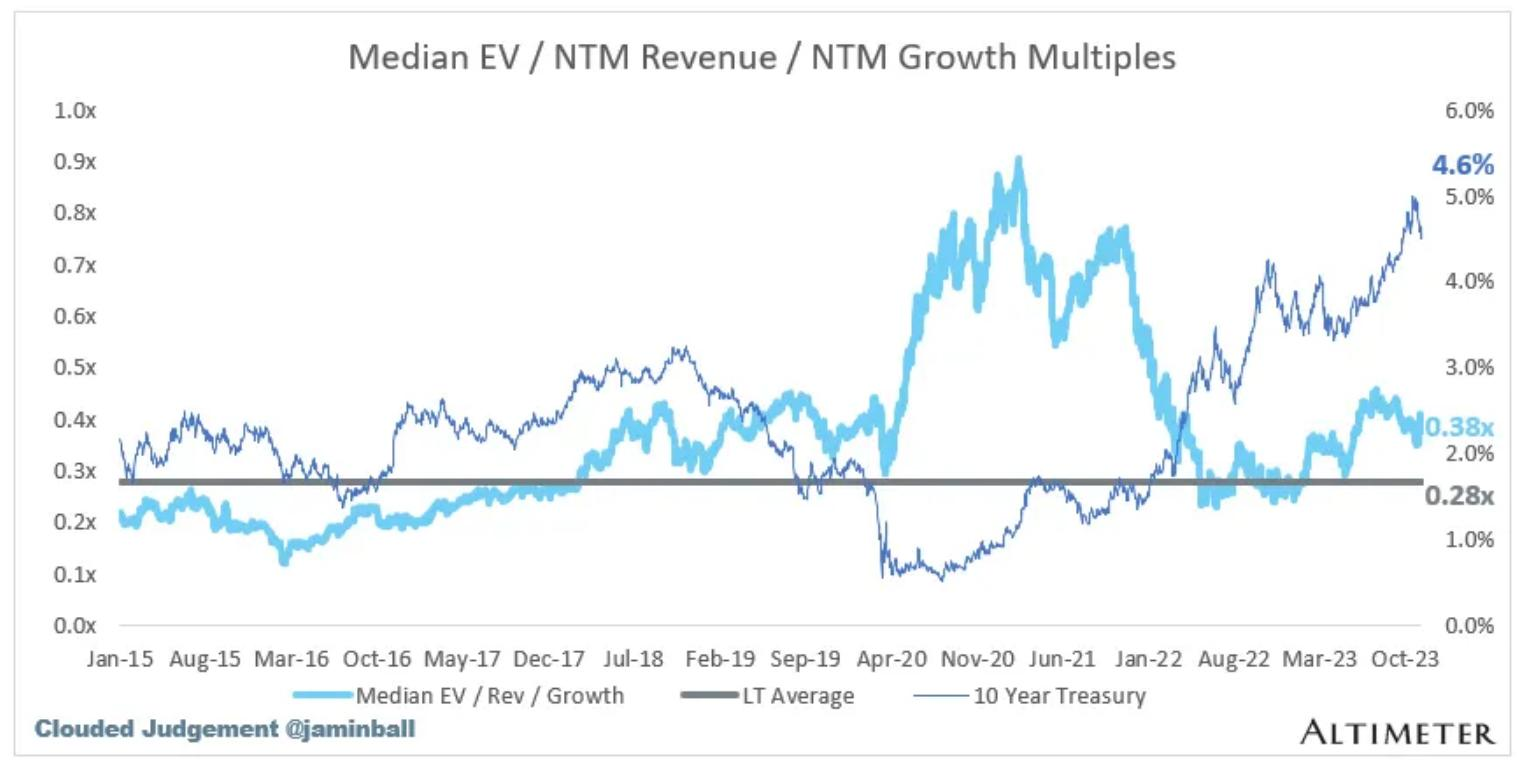

In [10]:
plt_img_base64(img_base64_list[3])

In [11]:
image_summaries[3]

'Graph showing trends in Median EV/NTM Revenue/NTM Growth Multiples from Jan 2015 to Oct 2023. Blue line represents Median EV/Rev/Growth, gray line shows LT Average, and dark blue indicates 10 Year Treasury. Labels include 0.38x, 0.28x, and 4.6%. Altimeter branding and "Clouded Judgement @jaminball" noted.'

# Response from LLM for the query

In [12]:
chain_multimodal_rag.invoke(query)

'Based on the provided data:\n\n1. **MongoDB**:\n   - EV / NTM Revenue: 14.6x\n   - NTM Revenue Growth: 17%\n\n2. **Cloudflare**:\n   - EV / NTM Revenue: 13.4x\n   - NTM Revenue Growth: 28%\n\n3. **Datadog**:\n   - EV / NTM Revenue: 13.1x\n   - NTM Revenue Growth: 19%\n\nThese metrics indicate that all three companies have relatively high EV/NTM revenue multiples, suggesting they are valued at a premium compared to the median of 5.0x. Cloudflare shows the highest expected revenue growth among the three, which might justify its valuation. MongoDB and Datadog also have strong growth prospects, but at slightly lower rates.'